In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!git clone -b master https://github.com/DeepTesla/deep_learning_hf.git

Cloning into 'deep_learning_hf'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 367 (delta 0), reused 0 (delta 0), pack-reused 366
Receiving objects: 100% (367/367), 738.76 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Checking out files: 100% (49/49), done.


In [3]:
%cd deep_learning_hf/

/content/deep_learning_hf


In [4]:
import cv2
import os
import logging
import numpy as np
import tensorflow as tf
import time
import timeit
from typing import Tuple, Iterator

logging.basicConfig(level=logging.INFO, format='[%(levelname)s]: %(message)s')


class VideoLoader:
    video_res = (640, 480)

    def __init__(self, video_dir_path: os.path):
        if not os.path.exists(video_dir_path):
            raise Exception(f'Path doesn\'t exist!\n{video_dir_path}')
        self.video_dir_path = video_dir_path
        self.orig_videos = {}
        self.annot_videos = {}
        self.load_videos()

    def load_videos(self) -> None:
        logging.info(f'loading video files from:\n{self.video_dir_path}')
        with os.scandir(self.video_dir_path) as entries:
            for e in entries:
                *name, ext = e.name.split('.')
                if ext == 'avi':
                    # get the sequence number
                    id, type_, *_ = name[0].split('_')
                    id = int(id)
                    video_full_path = os.path.join(self.video_dir_path, e.name)
                    if type_ == 'orig':
                        self.orig_videos[id] = video_full_path
                    elif type_ == 'annot':
                        self.annot_videos[id] = video_full_path

    def preprocess(self,
                   dst_size: Tuple[int, int],
                   dst_dir: os.path) -> None:
        o_dir = os.path.join(dst_dir, 'orig')
        a_dir = os.path.join(dst_dir, 'annot')
        try:
            os.makedirs(dst_dir)
        except:
            pass
        time.sleep(1)
        self._delete_dir(o_dir)
        os.makedirs(o_dir)
        time.sleep(1)
        self._delete_dir(a_dir)
        os.makedirs(a_dir)
        time.sleep(1)
        for o, a in zip(self.orig_videos.items(), self.annot_videos.items()):
            o_id, o_path = o
            a_id, a_path = a
            o_vc = cv2.VideoCapture(o_path)
            a_vc = cv2.VideoCapture(a_path)
            frame_cnt = 0
            while True:
                ret, o_frame_orig = o_vc.read()
                ret, a_frame_orig = a_vc.read()
                if o_frame_orig is None or a_frame_orig is None:
                    break
                o_frame_new = cv2.resize(o_frame_orig, dst_size)
                cv2.imwrite(os.path.join(o_dir, f'{frame_cnt:06d}.png'), o_frame_new)
                a_frame_new = cv2.resize(a_frame_orig, dst_size)
                cv2.imwrite(os.path.join(a_dir, f'{frame_cnt:06d}.png'), a_frame_new)
                frame_cnt += 1
            o_vc.release()
            a_vc.release()

    def data_generator(self,
                       src_dir: os.path,
                       src_size: Tuple[int, int],
                       batch_size: int,
                       idxs: np.ndarray = None) -> Iterator:
        o_dir = os.path.join(src_dir, 'orig')
        a_dir = os.path.join(src_dir, 'annot')
        total_cnt = len(os.listdir(o_dir))
        while True:
            # read batch size random indexed images
            t_idxs = np.random.randint(0, total_cnt, batch_size)
            if idxs is not None:
                t_idxs = idxs
            x_shape = (batch_size, src_size[1], src_size[0], 3)
            y_shape = (batch_size, src_size[1], src_size[0])
            x = np.zeros(shape=x_shape, dtype=np.float32)
            y = np.zeros(shape=y_shape, dtype=np.float32)

            for i, idx in enumerate(t_idxs):
                filename = f'{idx:06d}.png'
                x[i] = np.array(cv2.imread(os.path.join(o_dir, filename)), dtype=np.float16)
                y[i] = np.array(cv2.imread(os.path.join(a_dir, filename), cv2.IMREAD_GRAYSCALE), dtype=np.float16)

            yield x / 255, y / 255

    @staticmethod
    def _delete_dir(path: os.path) -> None:
        """
        :param path: dir path
        :return: None
        """
        if os.path.exists(path):
            for file in os.listdir(path):
                os.remove(os.path.join(path, file))
            time.sleep(1)  # stop for 1 sec for the os to be able to catch up
            os.rmdir(path)


train_dir = os.path.join(os.getcwd(), 'data', "train")
valid_dir = os.path.join(os.getcwd(), 'data', "validation")
test_dir = os.path.join(os.getcwd(), 'data', "test")

train_video_loader = VideoLoader(train_dir)
prep_small_dir = os.path.join(os.getcwd(), 'prep_small', 'train')
prep_large_dir = os.path.join(os.getcwd(), 'prep_large', 'train')
train_video_loader.preprocess((160, 120), prep_large_dir)
train_video_loader.preprocess((80, 60), prep_small_dir)

validation_video_loader = VideoLoader(valid_dir)
prep_small_dir = os.path.join(os.getcwd(), 'prep_small', 'validation')
prep_large_dir = os.path.join(os.getcwd(), 'prep_large', 'validation')
validation_video_loader.preprocess((160, 120), prep_large_dir)
validation_video_loader.preprocess((80, 60), prep_small_dir)

test_video_loader = VideoLoader(test_dir)
prep_small_dir = os.path.join(os.getcwd(), 'prep_small', 'test')
prep_large_dir = os.path.join(os.getcwd(), 'prep_large', 'test')
test_video_loader.preprocess((160, 120), prep_large_dir)
test_video_loader.preprocess((80, 60), prep_small_dir)

[INFO]: loading video files from:
/content/deep_learning_hf/data/train
[INFO]: loading video files from:
/content/deep_learning_hf/data/validation
[INFO]: loading video files from:
/content/deep_learning_hf/data/test


In [22]:
# TODO load models
from model0 import model0
from model1 import model1
from model2 import model2
from model3 import model3
from model4 import model4
from model5 import model5
from model6 import model6
from model7 import model7
from model8 import model8
from model9 import model9
from model10 import model10
from model11 import model11
from model12 import model12
from model13 import model13
from model14 import model14
from model15 import model15
import gc

models_large = {
   "model0": model0, 
   "model1": model1, 
   "model2": model2, 
   "model3": model3, 
   "model4": model4, 
   "model5": model5, 
   "model6": model6, 
   "model7": model7, 
   "model8": model8, 
   "model9": model9, 
   "model10": model10, 
   "model11": model11
}
models_small = {
    "model12": model12, 
    "model13": model13, 
    "model14": model14, 
    "model15": model15
}
# TODO train models

for key, model in models_large.items():
    checkpoint_name = f'{key}.hdf5'
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="binary_crossentropy", metrics=['acc'])
    if not os.path.exists(checkpoint_name):
        dg_train = train_video_loader.data_generator(prep_large_dir, (160, 120), 32)
        dg_valid = validation_video_loader.data_generator(prep_large_dir, (160, 120), 32)
        callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                                 monitor='val_loss',
                                                                 verbose=1,
                                                                 save_weights_only=True,
                                                                 save_best_only=True)

        callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                   patience=10, verbose=1)
        callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                  factor=0.1,
                                                                  patience=7,
                                                                  verbose=1,
                                                                  min_rl=1e-5)
        model.fit_generator(
                generator=dg_train,
                steps_per_epoch=20,
                epochs=50,
                verbose=1,
                validation_data=dg_valid,
                validation_steps=10,
                callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping]
        )
        gc.collect()

for key, model in models_small.items():
    checkpoint_name = f'{key}.hdf5'
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="binary_crossentropy", metrics=['acc'])
    if not os.path.exists(checkpoint_name):
        dg_train = train_video_loader.data_generator(prep_small_dir, (80, 60), 32)
        dg_valid = validation_video_loader.data_generator(prep_small_dir, (80, 60), 32)
        callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                                 monitor='val_loss',
                                                                 verbose=1,
                                                                 save_weights_only=True,
                                                                 save_best_only=True)

        callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                   patience=10, verbose=1)
        callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                  factor=0.1,
                                                                  patience=7,
                                                                  verbose=1,
                                                                  min_rl=1e-5)
        model.fit_generator(
                generator=dg_train,
                steps_per_epoch=20,
                epochs=50,
                verbose=1,
                validation_data=dg_valid,
                validation_steps=10,
                callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping]
        )
        gc.collect()

Epoch 1/50
19/20 [===========================>..] - ETA: 0s - loss: 0.3993 - acc: 0.7862
Epoch 00001: val_loss improved from inf to 1.67267, saving model to model0.hdf5
20/20 [==============================] - 14s 725ms/step - loss: 0.3933 - acc: 0.7907 - val_loss: 1.6727 - val_acc: 0.8402
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1917 - acc: 0.9173
Epoch 00002: val_loss did not improve from 1.67267
20/20 [==============================] - 14s 706ms/step - loss: 0.1891 - acc: 0.9187 - val_loss: 3.3775 - val_acc: 0.7097
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1190 - acc: 0.9498
Epoch 00003: val_loss improved from 1.67267 to 0.84996, saving model to model0.hdf5
20/20 [==============================] - 14s 711ms/step - loss: 0.1188 - acc: 0.9497 - val_loss: 0.8500 - val_acc: 0.8729
Epoch 4/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1018 - acc: 0.9552
Epoch 00004: val_loss did not improve from 0.84996
20/20 [=====

In [0]:
# TODO predict same images
inference_times = {}
parameters = {}
evaluations = {}

idxs = np.array([180])
dg_test_large = test_video_loader.data_generator(prep_large_dir, (160, 120), len(idxs), idxs)
x, y = next(dg_test_large)
for key, model in models_large.items():
    checkpoint_name = f'{key}.hdf5'
    model.load_weights(checkpoint_name)
    inf_sum = 0
    for r in range(100):
        start=time.time()
        p = model.predict(np.expand_dims(x[0], axis=0)) 
        elapsed = (time.time() - start)
        inf_sum += elapsed
    inf = inf_sum / 100
    for r in range(len(x)):
        a = np.array(x[r]) * 255
        b = np.zeros(shape=x[r].shape)
        c = np.zeros(shape=x[r].shape)
        p = np.array(p)
        # print(f"x {x.shape}")
        # print(f"y {y.shape}")
        # print(f"b {b.shape}")
        # print(f"c {c.shape}")
        # print(f"p {p.shape}")
        for i in range(120):
            for j in range(160):
                b[i, j, 0] = y[r][i, j]
                b[i, j, 1] = y[r][i, j]
                b[i, j, 2] = y[r][i, j]
                c[i, j, 0] = p[r][i, j]
                c[i, j, 1] = p[r][i, j]
                c[i, j, 2] = p[r][i, j]
        b = b * 255
        c = c * 255
        img = np.concatenate((a, b, c), axis=1)
        cv2.imwrite(f'{key}.png', img)
        inference_times[key] = inf
        parameters[key] = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
        evaluations[key] = model.evaluate_generator(dg_test_large, steps=1)

In [0]:
dg_test_small = test_video_loader.data_generator(prep_small_dir, (80, 60), len(idxs), idxs)
x, y = next(dg_test_small)
for key, model in models_small.items():
    checkpoint_name = f'{key}.hdf5'
    model.load_weights(checkpoint_name)
    inf_sum = 0
    for r in range(100):
        start=time.time()
        p = model.predict(np.expand_dims(x[0], axis=0)) 
        elapsed = (time.time() - start)
        inf_sum += elapsed
    inf = inf_sum / 100
    for r in range(len(x)):
        a = np.array(x[r]) * 255
        b = np.zeros(shape=x[r].shape)
        c = np.zeros(shape=x[r].shape)
        p = np.array(p)
        # print(f"x {x.shape}")
        # print(f"y {y.shape}")
        # print(f"b {b.shape}")
        # print(f"c {c.shape}")
        # print(f"p {p.shape}")
        for i in range(60):
            for j in range(80):
                b[i, j, 0] = y[r][i, j]
                b[i, j, 1] = y[r][i, j]
                b[i, j, 2] = y[r][i, j]
                c[i, j, 0] = p[r][i, j]
                c[i, j, 1] = p[r][i, j]
                c[i, j, 2] = p[r][i, j]
        b = b * 255
        c = c * 255
        img = np.concatenate((a, b, c), axis=1)
        cv2.imwrite(f'{key}_o.png', img)
        cv2.imwrite(f'{key}.png', cv2.resize(img, (480, 120)))
        inference_times[key] = inf
        parameters[key] = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
        evaluations[key] = model.evaluate_generator(dg_test_small, steps=1)

In [25]:
print(inference_times)

{'model0': 0.057782979011535646, 'model1': 0.04432043075561523, 'model2': 0.043025331497192384, 'model3': 0.039666662216186525, 'model4': 0.04791708707809448, 'model5': 0.0397718596458435, 'model6': 0.039354522228240964, 'model7': 0.05830360651016235, 'model8': 0.046806750297546384, 'model9': 0.03989019155502319, 'model10': 0.03952762842178345, 'model11': 0.038218801021575925, 'model12': 0.04098366022109985, 'model13': 0.03830743789672852, 'model14': 0.037571282386779786, 'model15': 0.03647993803024292}


In [26]:
print(parameters)

{'model0': 15348289, 'model1': 3840289, 'model2': 3839809, 'model3': 961441, 'model4': 3549761, 'model5': 890145, 'model6': 888641, 'model7': 223137, 'model8': 7089857, 'model9': 1775457, 'model10': 1774529, 'model11': 444897, 'model12': 3549761, 'model13': 890145, 'model14': 888641, 'model15': 223137}


In [27]:
print(evaluations)
accuracy = {}
for k, v in evaluations.items():
    accuracy[k] = v[1]
print(accuracy)

{'model0': [0.0072048199363052845, 0.9947917], 'model1': [0.01048349216580391, 0.9945313], 'model2': [0.01038816012442112, 0.9945313], 'model3': [0.34563925862312317, 0.8486979], 'model4': [0.027385804802179337, 0.9893229], 'model5': [0.15616968274116516, 0.94291663], 'model6': [0.15169657766819, 0.9303646], 'model7': [0.2310815155506134, 0.90015626], 'model8': [0.39719757437705994, 0.9060937], 'model9': [0.32606324553489685, 0.8447396], 'model10': [0.35468801856040955, 0.8461979], 'model11': [0.4791960120201111, 0.7765625], 'model12': [0.03633614256978035, 0.98583335], 'model13': [0.007828825153410435, 0.99666667], 'model14': [0.15766330063343048, 0.94395834], 'model15': [0.008242489770054817, 0.9972917]}
{'model0': 0.9947917, 'model1': 0.9945313, 'model2': 0.9945313, 'model3': 0.8486979, 'model4': 0.9893229, 'model5': 0.94291663, 'model6': 0.9303646, 'model7': 0.90015626, 'model8': 0.9060937, 'model9': 0.8447396, 'model10': 0.8461979, 'model11': 0.7765625, 'model12': 0.98583335, 'mod

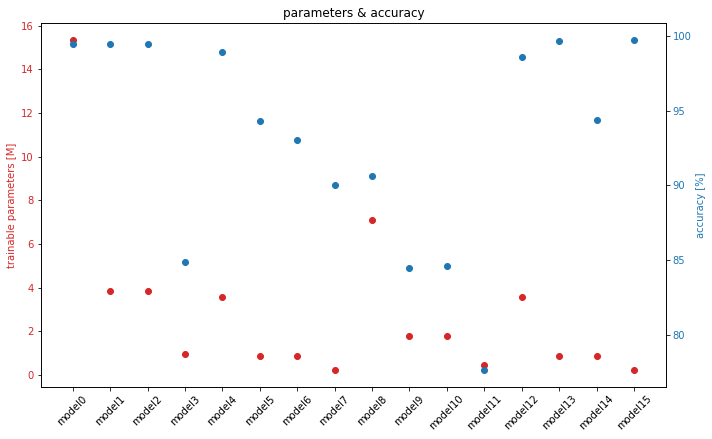

In [28]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))
x = [f"model{i}" for i in range(len(parameters))]
y = [parameters[k] for k in x]

# lists = sorted(parameters.items())
# x, y = zip(*lists)

color = 'tab:red'
# ax1.set_xlabel('model')
ax1.set_ylabel('trainable parameters [M]', color=color)
ax1.scatter(x, np.array(y)/1000000, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(x, rotation=45)

y = [accuracy[k] for k in x]

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy [%]', color=color)  # we already handled the x-label with ax1
ax2.scatter(x, np.array(y)*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('parameters & accuracy')
plt.show()

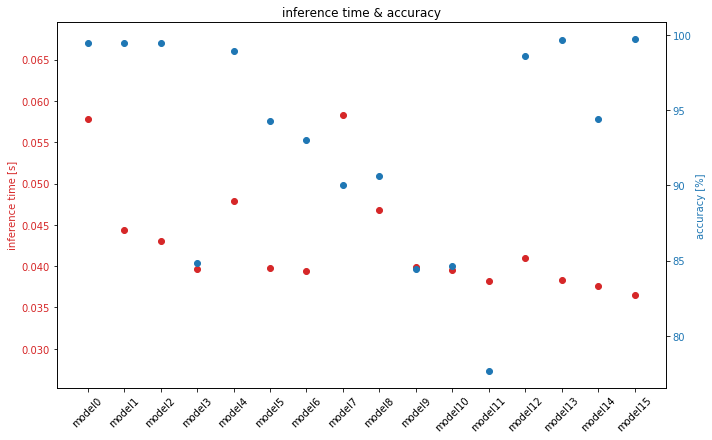

In [29]:
fig, ax1 = plt.subplots(figsize=(10,6))
x = [f"model{i}" for i in range(len(parameters))]
y = [inference_times[k] for k in x]

# lists = sorted(parameters.items())
# x, y = zip(*lists)

color = 'tab:red'
# ax1.set_xlabel('model')
ax1.set_ylabel('inference time [s]', color=color)
ax1.scatter(x, np.array(y), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(x, rotation=45)

y = [accuracy[k] for k in x]

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy [%]', color=color)  # we already handled the x-label with ax1
ax2.scatter(x, np.array(y)*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('inference time & accuracy')
plt.show()